In [7]:
import numpy as np
import pandas as pd

import yfinance as yf
import pandas_datareader as pdr

import plotly.graph_objs as go
import plotly.express as px

import time
from datetime import date, timedelta
import requests
import io

import matplotlib.pyplot as plt


# 1. IPOs data from Web.
* learn dataframes "stacking" (UNION ALL)
* learn about type casting
* generate new columns (simple and with function)



In [8]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
}

url = "https://stockanalysis.com/ipos/2023/"
response = requests.get(url, headers=headers)

ipo_dfs = pd.read_html(io.StringIO(response.text))
ipos_2023 = ipo_dfs[0]
ipos_2023.info()
     


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      154 non-null    object
 1   Symbol        154 non-null    object
 2   Company Name  154 non-null    object
 3   IPO Price     154 non-null    object
 4   Current       154 non-null    object
 5   Return        154 non-null    object
dtypes: object(6)
memory usage: 7.3+ KB


In [9]:
url = "https://stockanalysis.com/ipos/2024/"
response = requests.get(url, headers=headers)

ipo_dfs = pd.read_html(io.StringIO(response.text))
     

ipos_2024 = ipo_dfs[0]
ipos_2024.info()
     


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      64 non-null     object
 1   Symbol        64 non-null     object
 2   Company Name  64 non-null     object
 3   IPO Price     64 non-null     object
 4   Current       64 non-null     object
 5   Return        64 non-null     object
dtypes: object(6)
memory usage: 3.1+ KB


In [10]:
stacked_ipos_df = pd.concat([ipos_2024, ipos_2023], ignore_index=True)
    
stacked_ipos_df.head(1)    


,IPO Date,Symbol,Company Name,IPO Price,Current,Return
0,"May 1, 2024",VIK,Viking Holdings Ltd.,$24.00,$29.00,20.83%


In [11]:
stacked_ipos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      218 non-null    object
 1   Symbol        218 non-null    object
 2   Company Name  218 non-null    object
 3   IPO Price     218 non-null    object
 4   Current       218 non-null    object
 5   Return        218 non-null    object
dtypes: object(6)
memory usage: 10.3+ KB


In [13]:
# convert to datetime
stacked_ipos_df['IPO Date'] = pd.to_datetime(stacked_ipos_df['IPO Date'], format='mixed')

In [20]:


# it has some missing values --> use defensive errors='coerce' (if don't have time to crack into the data errors)
#     : pd.to_numeric() function call, which will convert problematic values to NaN.
#     otherwise you'll get a ValueError: Unable to parse string "-" at position 9
stacked_ipos_df['IPO Price'] = pd.to_numeric(stacked_ipos_df['IPO Price'].str.replace('$', ''), errors='coerce')
# not sure why, but need to call it again to transform 'object' to 'float64'
stacked_ipos_df['IPO Price'] = pd.to_numeric(stacked_ipos_df['IPO Price'])
     

# Convert "Current" column
stacked_ipos_df['Current'] = pd.to_numeric(stacked_ipos_df['Current'].str.replace('$', ''), errors='coerce')

# Convert 'Return' to numeric format (percentage)
stacked_ipos_df['Return'] = pd.to_numeric(stacked_ipos_df['Return'].str.replace('%', ''), errors='coerce') / 100
     

# Correctly applied transformations with 'defensive' techniques, but now not all are non-null
stacked_ipos_df.info()
     


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   IPO Date      218 non-null    datetime64[ns]
 1   Symbol        218 non-null    object        
 2   Company Name  218 non-null    object        
 3   IPO Price     218 non-null    float64       
 4   Current       218 non-null    float64       
 5   Return        218 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 10.3+ KB


In [21]:
# Problem --> not always the columns are filled
missing_prices_df = stacked_ipos_df[stacked_ipos_df['IPO Price'].astype(str).str.find('-') >= 0]
missing_prices_df

,IPO Date,Symbol,Company Name,IPO Price,Current,Return


In [22]:
stacked_ipos_df.isnull().sum()

IPO Date        0
Symbol          0
Company Name    0
IPO Price       0
Current         0
Return          0
dtype: int64

In [18]:
stacked_ipos_df[stacked_ipos_df.Return.isnull()]

,IPO Date,Symbol,Company Name,IPO Price,Current,Return


In [23]:
stacked_ipos_df['IPO Price'].mean()

11.060229357798166

In [24]:


# generate a new field -- SIMPLE calculation (no function needed)
stacked_ipos_df['Price Increase'] = stacked_ipos_df['Current'] - stacked_ipos_df['IPO Price']
     

stacked_ipos_df.head(1)
     


,IPO Date,Symbol,Company Name,IPO Price,Current,Return,Price Increase
0,2024-05-01,VIK,Viking Holdings Ltd.,24.0,29.0,0.2083,5.0


In [25]:
# Descriptive Analytics of a dataset
stacked_ipos_df.describe()

,IPO Date,IPO Price,Current,Return,Price Increase
count,218,218.000000,218.000000,218.000000,218.000000
mean,2023-09-08 03:44:35.229357824,11.060229,11.050367,-0.215149,-0.009862
min,2023-01-13 00:00:00,2.500000,0.000000,-0.999600,-21.980000
25%,2023-04-20 00:00:00,4.000000,1.252500,-0.731500,-3.660000
50%,2023-09-14 12:00:00,8.000000,5.320000,-0.213750,-1.795000
75%,2024-01-24 18:00:00,13.750000,10.825000,0.056500,0.542500
max,2024-05-01 00:00:00,92.000000,118.460000,2.471700,50.700000
std,NaN,11.245650,17.109080,0.637994,9.062540


In [26]:


# some visualisation: bar chart using Plotly Express
import plotly.express as px

# Truncate to the first day in the month - for Bar names
stacked_ipos_df['Date_monthly'] = stacked_ipos_df['IPO Date'].dt.to_period('M').dt.to_timestamp()

# Count the number of deals for each month and year
monthly_deals = stacked_ipos_df['Date_monthly'].value_counts().reset_index().sort_values(by='Date_monthly')
monthly_deals.columns = ['Date_monthly', 'Number of Deals']

# Plotting the bar chart using Plotly Express
fig = px.bar(monthly_deals,
             x='Date_monthly',
             y='Number of Deals',
             labels={'Month_Year': 'Month and Year', 'Number of Deals': 'Number of Deals'},
             title='Number of IPO Deals per Month and Year',
             text='Number of Deals'
             )
fig.update_traces(textposition='outside', # Position the text outside the bars
                  textfont=dict(color='black',size=14), # Adjust the font size of the text
                  )
fig.update_layout(title_x=0.5) # Center the title

fig.show()
     


In [27]:
# To be used for home assignment: 'You can notice a bump in the price after the IPO? And after that the price goes down
# You're asked to design a simple strategy to buy and hold for X days (at 'Adj.Close' price, no fees)
# Find an optimal X between 1 and 30, that delivers you a MAX mean return on ALL 2023 IPOs?
# Write down the answer X (a number between 1 and 30)

# What is the distribution of other returns 25-50-75% quantiles? Compare mean and median returns for 2023 (median may be more robust),
  # are you losing money in 25% cases (if 25% quantile returns is < 0)
  # Try the same X for all deals in 2024.  How the mean return in 2024 (out of sample data) is different from 2023 data?

# REDDIT - recent IPO
# https://finance.yahoo.com/quote/RDDT/
reddit = yf.download(tickers = "RDDT",
                     period = "max",
                     interval = "1d")

reddit.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-29,46.049999,48.880001,45.849998,46.279999,46.279999,2678300
2024-04-30,45.470001,46.755001,44.150002,44.439999,44.439999,1752900
2024-05-01,44.869999,47.700001,44.599998,45.880001,45.880001,1598100
2024-05-02,46.610001,49.639000,45.720001,47.700001,47.700001,2365000
2024-05-03,48.439999,48.700001,46.240002,46.639999,46.639999,1172338


<Axes: title={'center': "Reddit's (RDDT) price after the IPO"}, xlabel='Date'>

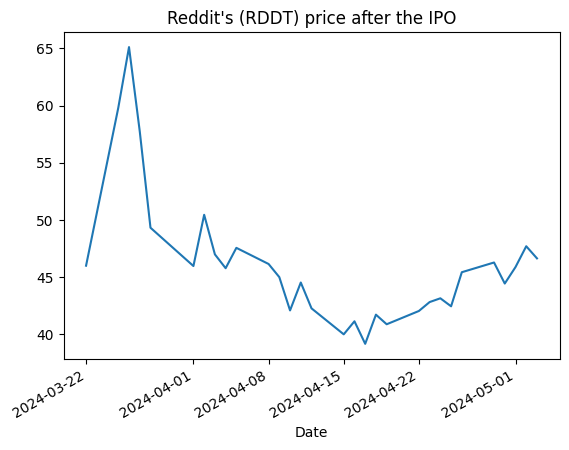

In [28]:
reddit['Adj Close'].plot.line(title='Reddit\'s (RDDT) price after the IPO')


# 2. OHLCV data transformations
## 2.1. Time series for OHLCV



In [30]:
nvo_df = yf.download(tickers = "NVO",
                     period = "max",
                    interval = "1d")
nvo_df.tail()
                    
                     

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-29,127.320000,127.970001,126.519997,126.879997,126.879997,1877000
2024-04-30,128.050003,130.460007,127.489998,128.309998,128.309998,7841000
2024-05-01,127.800003,130.130005,127.500000,129.210007,129.210007,5184400
2024-05-02,127.940002,127.940002,123.830002,124.019997,124.019997,8487100
2024-05-03,122.919998,123.769997,121.290199,123.050003,123.050003,5711197


<Axes: title={'center': 'Novo Nordisk A/S (NVO) price daily'}, xlabel='Date'>

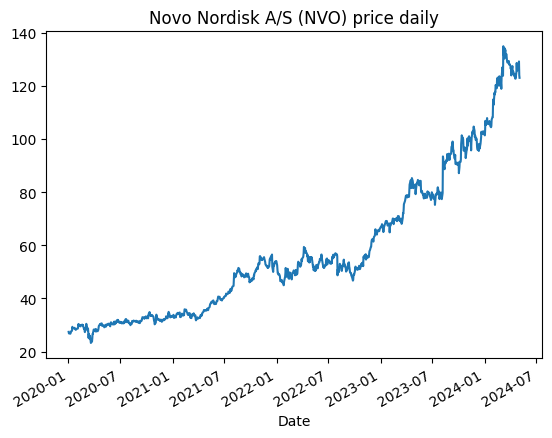

In [32]:
# filter on date (index)
nvo_df_filtered_from_2020 = nvo_df[nvo_df.index>='2020-01-01']
nvo_df_filtered_from_2024 = nvo_df[nvo_df.index>='2024-01-01']

# Chaining: select one column, draw a plot, of a type line
nvo_df_filtered_from_2020['Adj Close'].plot.line(title='Novo Nordisk A/S (NVO) price daily')

In [33]:


# generating new fields (using DateTime features):

nvo_df['Ticker'] = 'NVO'
nvo_df['Year']= nvo_df.index.year
nvo_df['Month'] = nvo_df.index.month
nvo_df['Weekday'] = nvo_df.index.weekday
nvo_df['Date'] = nvo_df.index.date # to be used in joins
     

nvo_df.tail()
     

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,Date
Date,,,,,,,,,,,
2024-04-29,127.320000,127.970001,126.519997,126.879997,126.879997,1877000,NVO,2024,4,0,2024-04-29
2024-04-30,128.050003,130.460007,127.489998,128.309998,128.309998,7841000,NVO,2024,4,1,2024-04-30
2024-05-01,127.800003,130.130005,127.500000,129.210007,129.210007,5184400,NVO,2024,5,2,2024-05-01
2024-05-02,127.940002,127.940002,123.830002,124.019997,124.019997,8487100,NVO,2024,5,3,2024-05-02
2024-05-03,122.919998,123.769997,121.290199,123.050003,123.050003,5711197,NVO,2024,5,4,2024-05-03


In [34]:

# shift ALL values (on x periods forward (+1) and backward (-1))
# equivalent of joining with a dataframe of the same vector, but with shifted date index
nvo_df['adj_close_minus_1'] = nvo_df['Adj Close'].shift(-1)
nvo_df['adj_close_plus_1'] = nvo_df['Adj Close'].shift(1)

nvo_df.tail()

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,Date,adj_close_minus_1,adj_close_plus_1
Date,,,,,,,,,,,,,
2024-04-29,127.320000,127.970001,126.519997,126.879997,126.879997,1877000,NVO,2024,4,0,2024-04-29,128.309998,126.849998
2024-04-30,128.050003,130.460007,127.489998,128.309998,128.309998,7841000,NVO,2024,4,1,2024-04-30,129.210007,126.879997
2024-05-01,127.800003,130.130005,127.500000,129.210007,129.210007,5184400,NVO,2024,5,2,2024-05-01,124.019997,128.309998
2024-05-02,127.940002,127.940002,123.830002,124.019997,124.019997,8487100,NVO,2024,5,3,2024-05-02,123.050003,129.210007
2024-05-03,122.919998,123.769997,121.290199,123.050003,123.050003,5711197,NVO,2024,5,4,2024-05-03,NaN,124.019997


In [35]:

# shift ALL values (on x periods forward (+1) and backward (-1))
# equivalent of joining with a dataframe of the same vector, but with shifted date index
nvo_df['adj_close_minus_1'] = nvo_df['Adj Close'].shift(-1)
nvo_df['adj_close_plus_1'] = nvo_df['Adj Close'].shift(1)

nvo_df.tail()

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,Date,adj_close_minus_1,adj_close_plus_1
Date,,,,,,,,,,,,,
2024-04-29,127.320000,127.970001,126.519997,126.879997,126.879997,1877000,NVO,2024,4,0,2024-04-29,128.309998,126.849998
2024-04-30,128.050003,130.460007,127.489998,128.309998,128.309998,7841000,NVO,2024,4,1,2024-04-30,129.210007,126.879997
2024-05-01,127.800003,130.130005,127.500000,129.210007,129.210007,5184400,NVO,2024,5,2,2024-05-01,124.019997,128.309998
2024-05-02,127.940002,127.940002,123.830002,124.019997,124.019997,8487100,NVO,2024,5,3,2024-05-02,123.050003,129.210007
2024-05-03,122.919998,123.769997,121.290199,123.050003,123.050003,5711197,NVO,2024,5,4,2024-05-03,NaN,124.019997


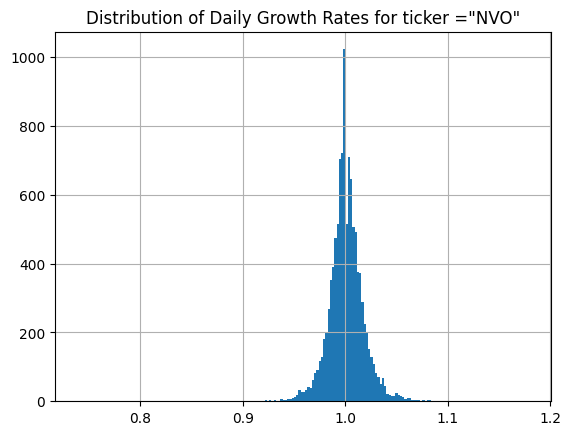

In [36]:


# historical growth
nvo_df['growth_1d'] = nvo_df['Adj Close'] / nvo_df['Adj Close'].shift(1)           # nvo_df['adj_close_plus_1']
nvo_df['growth_30d'] = nvo_df['Adj Close'] / nvo_df['Adj Close'].shift(30)

# FUTURE Growth : for regression models
nvo_df['growth_future_1d'] = nvo_df['Adj Close'].shift(-1) / nvo_df['Adj Close']   # nvo_df['adj_close_minus_1']

# FUTURE Growth: for binary models
nvo_df['is_positive_growth_1d_future'] = np.where(nvo_df['growth_future_1d'] > 1, 1, 0)
     

# normally the growth in 1 day is +-10%, while a lot of it is around 0% (around 1.)
plt.title('Distribution of Daily Growth Rates for ticker ="NVO"')
nvo_df.growth_1d.hist(bins=200)
plt.show()
     


<Axes: title={'center': 'Distribution of 2-days Growth Rates for ticker = "NVO"'}>

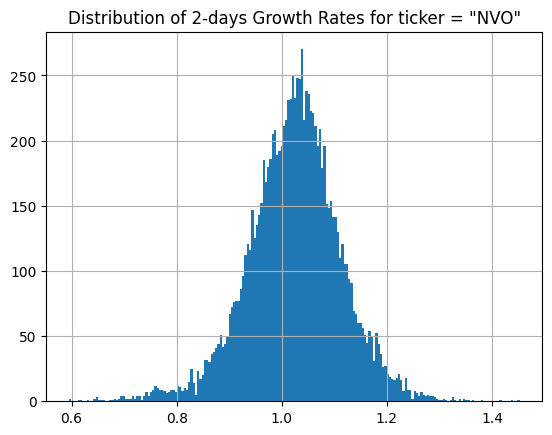

In [37]:
# you can see that the growth is can be much wider in 30 days (+- 30%)
plt.title('Distribution of 2-days Growth Rates for ticker = "NVO"')

nvo_df.growth_30d.hist(bins=200)

In [38]:
# for modeling: we use growth_1d, growth_2d as feature
COLUMNS = [k for k in nvo_df.keys() if k.find('growth')>=0 or k=='Adj Close']
nvo_df[COLUMNS].tail()

,Adj Close,growth_1d,growth_30d,growth_future_1d,is_positive_growth_1d_future
Date,,,,,
2024-04-29,126.879997,1.000236,0.965441,1.011270,1
2024-04-30,128.309998,1.011270,0.972502,1.007014,1
2024-05-01,129.210007,1.007014,0.990654,0.959833,0
2024-05-02,124.019997,0.959833,0.958229,0.992179,0
2024-05-03,123.050003,0.992179,0.954616,NaN,0


In [39]:

# Calculate the distribution if future growth
nvo_df.is_positive_growth_1d_future.value_counts() / len(nvo_df)
     

is_positive_growth_1d_future
0    0.51291
1    0.48709
Name: count, dtype: float64

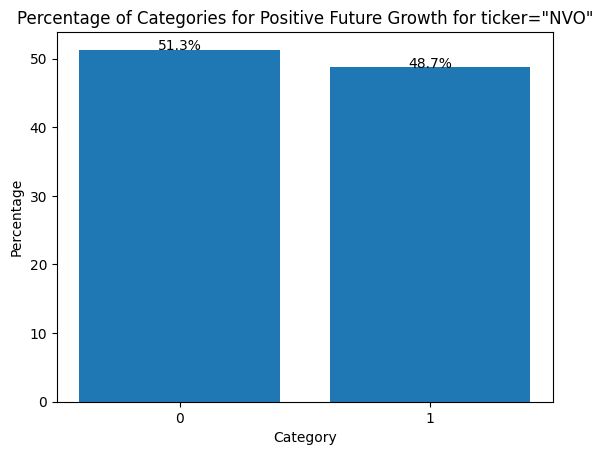

In [40]:

# Calculate value counts
value_counts = nvo_df['is_positive_growth_1d_future'].value_counts()

# Calculate percentage of each category
percentage = (value_counts / len(nvo_df)) * 100

# Plot as a bar chart
plt.bar(percentage.index.astype(str), percentage)
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.title('Percentage of Categories for Positive Future Growth for ticker="NVO"')

# Add percentage values on top of each bar
for i, value in enumerate(percentage):
    plt.text(i, value + 0, f'{value:.1f}%', ha='center')

plt.show()
     


## 2.2 Candlestick chart for OHLCV


In [41]:

# Candlestick charts : https://plotly.com/python/candlestick-charts/
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=nvo_df_filtered_from_2020.index,
                open=nvo_df_filtered_from_2020.Open,
                high=nvo_df_filtered_from_2020.High,
                low=nvo_df_filtered_from_2020.Low,
                close=nvo_df_filtered_from_2020.Close)
               ])

fig.update_layout(
    title="NVO's daily candlestick chart from 2020",
    title_x=0.5,  # Set title x-position to center
    xaxis_rangeslider_visible=True
    )

fig.show()
     


# 3. Macro Indicators
## 3.0 Previous indicators from module 1

In [42]:
end = date.today()
print(f'Year = {end.year}; month= {end.month}; day={end.day}')

start = date(year=end.year-70, month=end.month, day=end.day)
print(f'Period for indexes: {start} to {end} ')

Year = 2024; month= 5; day=4
Period for indexes: 1954-05-04 to 2024-05-04 


In [43]:
# reuse code for ealier covered indicators
dax_daily = yf.download(tickers = "^GDAXI",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [44]:

for i in [1,3,7,30,90,365]:
  #DEBUG: dax_daily['Adj Close_sh_m_'+str(i)+'d'] = dax_daily['Adj Close'].shift(i)
  dax_daily['growth_dax_'+str(i)+'d'] = dax_daily['Adj Close'] / dax_daily['Adj Close'].shift(i)
dax_daily.head()  

,Open,High,Low,Close,Adj Close,Volume,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,,,,,,,
1987-12-30,1005.190002,1005.190002,1005.190002,1005.190002,1005.190002,0,NaN,NaN,NaN,NaN,NaN,NaN
1988-01-04,956.489990,956.489990,956.489990,956.489990,956.489990,0,0.951551,NaN,NaN,NaN,NaN,NaN
1988-01-05,996.099976,996.099976,996.099976,996.099976,996.099976,0,1.041412,NaN,NaN,NaN,NaN,NaN
1988-01-06,1006.010010,1006.010010,1006.010010,1006.010010,1006.010010,0,1.009949,1.000816,NaN,NaN,NaN,NaN
1988-01-07,1014.469971,1014.469971,1014.469971,1014.469971,1014.469971,0,1.008409,1.060617,NaN,NaN,NaN,NaN


In [45]:
dax_daily.tail(2)

,Open,High,Low,Close,Adj Close,Volume,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,,,,,,,
2024-05-02,17935.779297,17981.039062,17875.980469,17896.500000,17896.500000,71332200,0.998011,0.985435,1.001999,0.997982,1.069530,1.230883
2024-05-03,17900.150391,18105.820312,17900.019531,18001.599609,18001.599609,0,1.005873,0.993558,0.992499,1.000784,1.078753,1.237957


In [46]:
GROWTH_KEYS = [k for k in dax_daily.keys() if k.startswith('growth')]
dax_daily_to_merge = dax_daily[GROWTH_KEYS]
dax_daily_to_merge.tail(1)

,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,
2024-05-03,1.005873,0.993558,0.992499,1.000784,1.078753,1.237957


In [47]:
def get_growth_df(df:pd.DataFrame, prefix:str)->pd.DataFrame:
  for i in [1,3,7,30,90,365]:
    df['growth_'+prefix+'_'+str(i)+'d'] = df['Adj Close'] / df['Adj Close'].shift(i)
    GROWTH_KEYS = [k for k in df.keys() if k.startswith('growth')]
  return df[GROWTH_KEYS]

In [48]:
# https://finance.yahoo.com/quote/%5EGSPC/
# SNP - SNP Real Time Price. Currency in USD
snp500_daily = yf.download(tickers = "^GSPC",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [49]:
snp500_to_merge = get_growth_df(snp500_daily,'snp500')
snp500_to_merge.tail(2)   


,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d
Date,,,,,,
2024-05-02,1.009128,0.989842,0.998748,0.969295,1.066877,1.279229
2024-05-03,1.012557,1.018289,1.011073,0.978300,1.078484,1.299306


In [51]:
# Dow Jones Industrial Average: https://finance.yahoo.com/quote/%5EDJI?.tsrc=fin-srch
dji_daily = yf.download(tickers = "^DJI",
                     period = "max",
                     interval = "1d")
dji_daily_to_merge = get_growth_df(dji_daily,'dji')
dji_daily_to_merge.tail(2)     


[*********************100%%**********************]  1 of 1 completed


,growth_dji_1d,growth_dji_3d,growth_dji_7d,growth_dji_30d,growth_dji_90d,growth_dji_365d
Date,,,,,,
2024-05-02,1.008505,0.995821,0.992779,0.967441,1.021958,1.139234
2024-05-03,1.011773,1.022735,1.005584,0.972206,1.034497,1.152904


In [53]:
# ETFs
# WisdomTree India Earnings Fund (EPI)
# NYSEArca - Nasdaq Real Time Price. Currency in USD
# WEB: https://finance.yahoo.com/quote/EPI/history?p=EPI
epi_etf_daily = yf.download(tickers = "EPI",
                     period = "max",
                     interval = "1d")
epi_etf_daily.tail(2)
     


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-02,45.549999,45.750000,45.450001,45.700001,45.700001,1492000
2024-05-03,45.480000,45.560001,45.410000,45.560001,45.560001,1121079


In [54]:

epi_etf_daily_to_merge = get_growth_df(epi_etf_daily,'epi')
epi_etf_daily_to_merge.tail(2)

,growth_epi_1d,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d
Date,,,,,,
2024-05-02,1.010168,1.005501,1.024204,1.073022,1.131188,1.393630
2024-05-03,0.996937,1.008857,1.019239,1.066230,1.122997,1.390207


In [55]:
# Real Potential Gross Domestic Product (GDPPOT), Billions of Chained 2012 Dollars, QUARTERLY
# https://fred.stlouisfed.org/series/GDPPOT
gdppot = pdr.DataReader("GDPPOT", "fred", start=start)
gdppot['gdppot_us_yoy'] = gdppot.GDPPOT/gdppot.GDPPOT.shift(4)-1
gdppot['gdppot_us_qoq'] = gdppot.GDPPOT/gdppot.GDPPOT.shift(1)-1
gdppot.tail(2)

,GDPPOT,gdppot_us_yoy,gdppot_us_qoq
DATE,,,
2024-01-01,22618.15,0.022251,0.005466
2024-04-01,22739.00,0.022151,0.005343


In [56]:
gdppot_to_merge = gdppot[['gdppot_us_yoy','gdppot_us_qoq']]
gdppot_to_merge.tail(1)

,gdppot_us_yoy,gdppot_us_qoq
DATE,,
2024-04-01,0.022151,0.005343


In [57]:
# # "Core CPI index", MONTHLY
# https://fred.stlouisfed.org/series/CPILFESL
# The "Consumer Price Index for All Urban Consumers: All Items Less Food & Energy"
# is an aggregate of prices paid by urban consumers for a typical basket of goods, excluding food and energy.
# This measurement, known as "Core CPI," is widely used by economists because food and energy have very volatile prices.
cpilfesl = pdr.DataReader("CPILFESL", "fred", start=start)
cpilfesl['cpi_core_yoy'] = cpilfesl.CPILFESL/cpilfesl.CPILFESL.shift(12)-1
cpilfesl['cpi_core_mom'] = cpilfesl.CPILFESL/cpilfesl.CPILFESL.shift(1)-1

cpilfesl.tail(2)

,CPILFESL,cpi_core_yoy,cpi_core_mom
DATE,,,
2024-02-01,315.565,0.037620,0.003584
2024-03-01,316.698,0.037973,0.003590


In [58]:
cpilfesl_to_merge = cpilfesl[['cpi_core_yoy','cpi_core_mom']]
cpilfesl_to_merge.tail(2)

,cpi_core_yoy,cpi_core_mom
DATE,,
2024-02-01,0.037620,0.003584
2024-03-01,0.037973,0.003590


In [59]:

# Fed rate https://fred.stlouisfed.org/series/FEDFUNDS
fedfunds = pdr.DataReader("FEDFUNDS", "fred", start=start)
fedfunds.tail(2)

,FEDFUNDS
DATE,
2024-03-01,5.33
2024-04-01,5.33


In [60]:

# https://fred.stlouisfed.org/series/DGS1
dgs1 = pdr.DataReader("DGS1", "fred", start=start)
dgs1.tail(2)

,DGS1
DATE,
2024-05-01,5.21
2024-05-02,5.16


In [61]:

# https://fred.stlouisfed.org/series/DGS5
dgs5 = pdr.DataReader("DGS5", "fred", start=start)
dgs5.tail(2)

,DGS5
DATE,
2024-05-01,4.64
2024-05-02,4.57


In [62]:


# https://fred.stlouisfed.org/series/DGS10
dgs10 = pdr.DataReader("DGS10", "fred", start=start)
dgs10.tail(2)
     


,DGS10
DATE,
2024-05-01,4.63
2024-05-02,4.58



## 3.1 VIX - Volatility Index


In [63]:


# VIX - Volatility Index
# https://finance.yahoo.com/quote/%5EVIX/
vix = yf.download(tickers = "^VIX",
                     period = "max",
                     interval = "1d")
     
vix.tail(2)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-02,15.14,16.09,14.60,14.68,14.68,0
2024-05-03,14.51,14.58,13.48,13.49,13.49,0


In [64]:

vix_to_merge = vix['Adj Close']
vix_to_merge.tail()   


Date
2024-04-29    14.67
2024-04-30    15.65
2024-05-01    15.39
2024-05-02    14.68
2024-05-03    13.49
Name: Adj Close, dtype: float64

<Axes: title={'center': 'VIX value over time'}, xlabel='Date'>

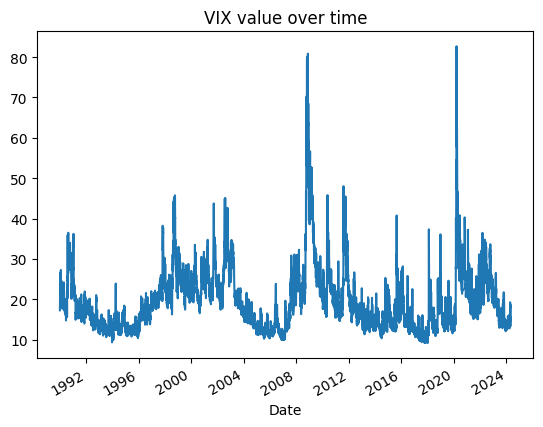

In [65]:

# Static graphs: hard to zoom in and get the exact dates of spikes
vix['Adj Close'].plot.line(title = "VIX value over time")


## 3.2 Gold - other assets


In [67]:
# GOLD
# WEB: https://finance.yahoo.com/quote/GC%3DF
gold = yf.download(tickers = "GC=F",
                     period = "max",
                     interval = "1d")
gold.tail(1)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-03,2300.0,2301.0,2277.600098,2299.0,2299.0,56


In [68]:


gold_to_merge = get_growth_df(gold,'gold')
gold_to_merge.tail(2)
     


,growth_gold_1d,growth_gold_3d,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d
Date,,,,,,
2024-05-02,0.999696,0.980302,0.987756,1.065480,1.127556,1.305770
2024-05-03,0.999913,1.003317,0.989030,1.053427,1.117593,1.312289


In [69]:
# Dynamic visualisation of GOLD prices
fig = px.line(gold,
              x=gold.index,
              y="Adj Close",
              title='GOLD over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

In [70]:

# WTI Crude Oil
# WEB: https://uk.finance.yahoo.com/quote/CL=F/
crude_oil = yf.download(tickers = "CL=F",
                     period = "max",
                     interval = "1d")
crude_oil.tail(2)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-02,79.150002,79.900002,78.410004,78.949997,78.949997,359652
2024-05-03,79.070000,79.629997,77.959999,78.110001,78.110001,359652


In [71]:

crude_oil_to_merge = get_growth_df(crude_oil,'wti_oil')
crude_oil_to_merge.tail(2)

,growth_wti_oil_1d,growth_wti_oil_3d,growth_wti_oil_7d,growth_wti_oil_30d,growth_wti_oil_90d,growth_wti_oil_365d
Date,,,,,,
2024-05-02,0.999367,0.955464,0.947097,0.966577,1.068480,0.96705
2024-05-03,0.989360,0.953375,0.943244,0.963488,1.061854,0.97540


In [72]:

# Dynamic visualisation
fig = px.line(crude_oil,
              x=crude_oil.index,
              y="Adj Close",
              title='WTI Crude Oil over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

In [73]:
# Brent Oil
# WEB: https://uk.finance.yahoo.com/quote/BZ=F/
brent_oil = yf.download(tickers = "BZ=F",
                     period = "max",
                     interval = "1d")

brent_oil.tail(2)
     

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-02,83.559998,84.419998,83.029999,83.669998,83.669998,39951
2024-05-03,83.800003,84.400002,82.800003,82.959999,82.959999,39951


In [74]:
brent_oil_to_merge = get_growth_df(brent_oil,'brent_oil')
brent_oil_to_merge.tail(2)

,growth_brent_oil_1d,growth_brent_oil_3d,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d
Date,,,,,,
2024-05-02,1.002756,0.946493,0.946279,0.973473,1.053911,0.931945
2024-05-03,0.991514,0.944229,0.942513,0.967125,1.049197,0.946816


In [75]:

# Dynamic visualisation
fig = px.line(brent_oil,
              x=brent_oil.index,
              y="Adj Close",
              title='Brent Oil over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()


## 3.4 Bitcoin prices: BTC_USD


In [76]:


# https://finance.yahoo.com/quote/BTC-USD/
btc_usd =  yf.download(tickers = "BTC-USD",
                     period = "max",
                     interval = "1d")

btc_usd.tail(2)
     


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-03,59122.300781,63320.503906,58848.312500,62889.835938,62889.835938,33172023048
2024-05-04,62911.718750,64446.613281,62661.035156,63617.722656,63617.722656,24002541568


In [77]:

btc_usd_to_merge = get_growth_df(btc_usd,'btc_usd')
btc_usd_to_merge.tail(2)

,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
Date,,,,,,
2024-05-03,1.063704,1.037155,0.986425,0.953153,1.462818,2.180063
2024-05-04,1.011574,1.092075,1.003131,0.928606,1.493950,2.154022


In [78]:
# Dynamic visualisation
fig = px.line(btc_usd,
              x=btc_usd.index,
              y="Adj Close",
              title='Bitcoin price daily')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

## 3.5 Eurostat: "The home of high-quality statistics and data on Europe"

In [79]:
import eurostat

filter_pars = {'startPeriod':'2024-04-01', 'endPeriod':'2024-05-01'}

code = 'irt_euryld_d'
eurostat_euro_yield_df = eurostat.get_data_df(code, flags=True, filter_pars=filter_pars,  verbose=True)

Download progress: 100.0%



In [80]:
eurostat_euro_yield_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2148 entries, 0 to 2147
Data columns (total 45 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   freq              2148 non-null   object 
 1   yld_curv          2148 non-null   object 
 2   maturity          2148 non-null   object 
 3   bonds             2148 non-null   object 
 4   geo\TIME_PERIOD   2148 non-null   object 
 5   2024-04-02_value  2148 non-null   float64
 6   2024-04-02_flag   2148 non-null   object 
 7   2024-04-03_value  2148 non-null   float64
 8   2024-04-03_flag   2148 non-null   object 
 9   2024-04-04_value  2148 non-null   float64
 10  2024-04-04_flag   2148 non-null   object 
 11  2024-04-05_value  2148 non-null   float64
 12  2024-04-05_flag   2148 non-null   object 
 13  2024-04-08_value  2148 non-null   float64
 14  2024-04-08_flag   2148 non-null   object 
 15  2024-04-09_value  2148 non-null   float64
 16  2024-04-09_flag   2148 non-null   object 


In [81]:
eurostat_euro_yield_df.head()

,freq,yld_curv,maturity,bonds,geo\TIME_PERIOD,2024-04-02_value,2024-04-02_flag,2024-04-03_value,2024-04-03_flag,2024-04-04_value,...,2024-04-23_value,2024-04-23_flag,2024-04-24_value,2024-04-24_flag,2024-04-25_value,2024-04-25_flag,2024-04-26_value,2024-04-26_flag,2024-04-29_value,2024-04-29_flag
0,D,INS_FWD,M10,CGB_EA,EA,2.93540,,2.97183,,2.92502,...,3.02264,,3.08430,,3.13182,,3.08867,,3.06128,
1,D,INS_FWD,M10,CGB_EA_AAA,EA,2.84475,,2.86360,,2.83422,...,2.91176,,2.96612,,3.01979,,2.98661,,2.95786,
2,D,INS_FWD,M11,CGB_EA,EA,2.87170,,2.90848,,2.85814,...,2.96704,,3.03342,,3.08275,,3.03647,,3.00758,
3,D,INS_FWD,M11,CGB_EA_AAA,EA,2.76744,,2.78547,,2.75286,...,2.84353,,2.90169,,2.95777,,2.92274,,2.89261,
4,D,INS_FWD,M3,CGB_EA,EA,3.61646,,3.63975,,3.62033,...,3.59855,,3.61313,,3.64745,,3.63097,,3.61332,


In [82]:
eurostat_euro_yield_df['bonds'].value_counts()

bonds
CGB_EA        1074
CGB_EA_AAA    1074
Name: count, dtype: int64

In [83]:
eurostat_euro_yield_df['maturity'].value_counts()

maturity
M10       6
Y26_M8    6
Y28_M4    6
Y28_M3    6
Y28_M2    6
         ..
Y18_M9    6
Y18_M8    6
Y18_M7    6
Y18_M6    6
Y9_M9     6
Name: count, Length: 358, dtype: int64

In [84]:
eurostat_euro_yield_df['yld_curv'].value_counts()

yld_curv
INS_FWD    716
PAR        716
SPOT_RT    716
Name: count, dtype: int64

In [85]:
eurostat_euro_yield_df

,freq,yld_curv,maturity,bonds,geo\TIME_PERIOD,2024-04-02_value,2024-04-02_flag,2024-04-03_value,2024-04-03_flag,2024-04-04_value,...,2024-04-23_value,2024-04-23_flag,2024-04-24_value,2024-04-24_flag,2024-04-25_value,2024-04-25_flag,2024-04-26_value,2024-04-26_flag,2024-04-29_value,2024-04-29_flag
0,D,INS_FWD,M10,CGB_EA,EA,2.93540,,2.97183,,2.92502,...,3.02264,,3.08430,,3.13182,,3.08867,,3.06128,
1,D,INS_FWD,M10,CGB_EA_AAA,EA,2.84475,,2.86360,,2.83422,...,2.91176,,2.96612,,3.01979,,2.98661,,2.95786,
2,D,INS_FWD,M11,CGB_EA,EA,2.87170,,2.90848,,2.85814,...,2.96704,,3.03342,,3.08275,,3.03647,,3.00758,
3,D,INS_FWD,M11,CGB_EA_AAA,EA,2.76744,,2.78547,,2.75286,...,2.84353,,2.90169,,2.95777,,2.92274,,2.89261,
4,D,INS_FWD,M3,CGB_EA,EA,3.61646,,3.63975,,3.62033,...,3.59855,,3.61313,,3.64745,,3.63097,,3.61332,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,D,SPOT_RT,Y9_M7,CGB_EA_AAA,EA,2.46991,,2.46791,,2.39559,...,2.54635,,2.62834,,2.68168,,2.60908,,2.57881,
2144,D,SPOT_RT,Y9_M8,CGB_EA,EA,3.05403,,3.06662,,2.97186,...,3.07345,,3.16620,,3.23291,,3.14712,,3.10632,
2145,D,SPOT_RT,Y9_M8,CGB_EA_AAA,EA,2.47321,,2.47116,,2.39873,...,2.54935,,2.63147,,2.68473,,2.61196,,2.58177,
2146,D,SPOT_RT,Y9_M9,CGB_EA,EA,3.05847,,3.07104,,2.97618,...,3.07734,,3.17017,,3.23687,,3.15093,,3.11021,


In [86]:
FILTER = (eurostat_euro_yield_df.yld_curv=='SPOT_RT')& (eurostat_euro_yield_df.bonds=='CGB_EA_AAA')
filtered_eurostat_euro_yield_df = eurostat_euro_yield_df[FILTER]
     

filtered_eurostat_euro_yield_df.sort_values(by='maturity')[['maturity','2024-04-18_value']].head(20)
     


,maturity,2024-04-18_value
1433,M10,3.36335
1435,M11,3.31940
1437,M3,3.72264
1439,M4,3.66536
1441,M5,3.61017
1443,M6,3.55700
1445,M7,3.50580
1447,M8,3.45649
1449,M9,3.40903
1451,Y1,3.27711


In [87]:

import re

def extract_numbers(input_string):
    y_match = re.search(r'Y(\d+)', input_string)
    m_match = re.search(r'M(\d+)', input_string)

    y_number = int(y_match.group(1)) if y_match else 0
    m_number = int(m_match.group(1)) if m_match else 0


    return y_number*12 + m_number

# Examples
examples = ["Y10_M2", "M3", "Y1"]
for example in examples:
    res = extract_numbers(example)
    print(f"{example} ==> {res}")

Y10_M2 ==> 122
M3 ==> 3
Y1 ==> 12


In [88]:
 # define new field: "maturity in months"
filtered_eurostat_euro_yield_df['maturity_in_months'] = filtered_eurostat_euro_yield_df.maturity.apply(lambda x:extract_numbers(x))
     

/tmp/ipykernel_12916/3692369822.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [89]:
filtered_eurostat_euro_yield_df.sort_values(by='maturity_in_months')[['maturity','maturity_in_months','2024-04-18_value']].head(20)

,maturity,maturity_in_months,2024-04-18_value
1437,M3,3,3.72264
1439,M4,4,3.66536
1441,M5,5,3.61017
1443,M6,6,3.55700
1445,M7,7,3.50580
1447,M8,8,3.45649
1449,M9,9,3.40903
1433,M10,10,3.36335
1435,M11,11,3.31940
1451,Y1,12,3.27711


In [90]:
filtered_eurostat_euro_yield_df.loc[:,'maturity_in_years'] = filtered_eurostat_euro_yield_df.maturity_in_months/12.0

/tmp/ipykernel_12916/2163179308.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: title={'center': 'AAA rated bonds spot yield curve'}, xlabel='maturity_in_years'>

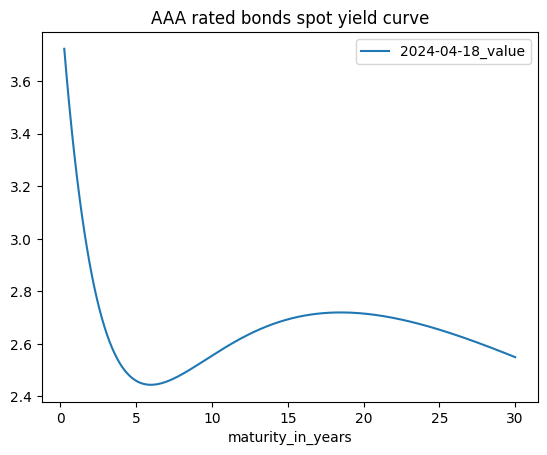

In [91]:

# exactly the same as on the Web:  https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html
filtered_eurostat_euro_yield_df \
  .sort_values(by='maturity_in_months')[['maturity_in_years','2024-04-18_value']] \
  .plot.line(x='maturity_in_years',
            y='2024-04-18_value',
            title='AAA rated bonds spot yield curve')


## 4. Fundamental indicators
* Read about "Ratio Analysis" to learn about more ratios: https://www.investopedia.com/terms/r/ratioanalysis.asp
* https://algotrading101.com/learn/yahoo-finance-api-guide/



In [92]:


# let's select some set of stocks: e.g. top US companies on 'Employees':
# https://companiesmarketcap.com/usa/largest-american-companies-by-number-of-employees/

US_TOP_EMPLOYEES_STOCKS = ['WMT','AMZN','UPS','HD','CNXC','TGT','KR','UNH','BRK-B','SBUX']

# WMT
ticker = US_TOP_EMPLOYEES_STOCKS[0]

# WMT ticker
one_company = yf.Ticker(ticker)
     

# Fundamental info appears close earning dates, you need to download it and use quickly (before/after trading day),
#  unless you're a fundamental long-term investor looking for a several months-quarters-years strategy (period between buy and sell)
# This dfthis is the easiest thing to join with the main dataset and get "some" technical indicators present
eps_earnings = one_company.earnings_dates
eps_earnings['Ticker'] = ticker
eps_earnings
     


,EPS Estimate,Reported EPS,Surprise(%),Ticker
Earnings Date,,,,
2025-06-05 11:00:00-04:00,0.49,NaN,NaN,WMT
2025-02-20 08:00:00-05:00,NaN,NaN,NaN,WMT
2024-11-19 08:00:00-05:00,NaN,NaN,NaN,WMT
2024-08-15 08:00:00-04:00,NaN,NaN,NaN,WMT
2024-06-05 11:00:00-04:00,0.52,NaN,NaN,WMT
2024-05-16 08:00:00-04:00,0.52,NaN,NaN,WMT
2024-04-10 06:00:00-04:00,0.55,0.6,0.0909,WMT
2024-04-03 06:00:00-04:00,0.55,0.6,0.0909,WMT
2024-03-28 06:00:00-04:00,0.55,0.6,0.0909,WMT


In [93]:
one_company.calendar

{'Dividend Date': datetime.date(2025, 1, 6),
 'Ex-Dividend Date': datetime.date(2024, 5, 9),
 'Earnings Date': [datetime.date(2024, 5, 16)],
 'Earnings High': 0.55,
 'Earnings Low': 0.51,
 'Earnings Average': 0.52,
 'Revenue High': 160755000000,
 'Revenue Low': 157591000000,
 'Revenue Average': 159344000000}

In [94]:
one_company.financials

,2024-01-31,2023-01-31,2022-01-31,2021-01-31
Tax Effect Of Unusual Items,0.0,0.0,-612140000.0,0.0
Tax Rate For Calcs,0.255,0.336,0.254,0.333
Normalized EBITDA,36384000000.0,30089000000.0,33758000000.0,34031000000.0
Total Unusual Items,0.0,0.0,-2410000000.0,0.0
Total Unusual Items Excluding Goodwill,0.0,0.0,-2410000000.0,0.0
Net Income From Continuing Operation Net Minority Interest,15511000000.0,11680000000.0,13673000000.0,13510000000.0
Reconciled Depreciation,11853000000.0,10945000000.0,10658000000.0,11152000000.0
Reconciled Cost Of Revenue,490142000000.0,463721000000.0,429000000000.0,420315000000.0
EBITDA,36384000000.0,30089000000.0,31348000000.0,34031000000.0
EBIT,24531000000.0,19144000000.0,20690000000.0,22879000000.0


In [95]:


EPS = one_company.financials.loc['Basic EPS']
EPS
     


2024-01-31    1.92
2023-01-31    1.43
2022-01-31    1.63
2021-01-31    1.59
Name: Basic EPS, dtype: object

In [96]:


# or should we use NORMALIZED_EBITDA?
EBITDA = one_company.financials.loc['EBITDA']
EBITDA_margin = one_company.financials.loc['EBITDA'] /  one_company.financials.loc['Total Revenue']
     

EBITDA_margin
     


2024-01-31    0.056137
2023-01-31    0.049222
2022-01-31    0.054732
2021-01-31    0.060862
dtype: object

In [99]:
NET_INCOME = one_company.financials.loc['Net Income']
NET_INCOME_margin = one_company.financials.loc['Net Income'] /  one_company.financials.loc['Total Revenue']  

NET_INCOME   

2024-01-31    15511000000.0
2023-01-31    11680000000.0
2022-01-31    13673000000.0
2021-01-31    13510000000.0
Name: Net Income, dtype: object

In [100]:
# Combine the series into a DataFrame
df_fin_ratios = pd.DataFrame({
    'NET_INCOME_margin': 100.0 * NET_INCOME_margin, #for visualisation -- Margin in %
    'EBITDA_margin': 100.0 *EBITDA_margin, #for visualisation -- Margin in %
    'EPS': EPS
})

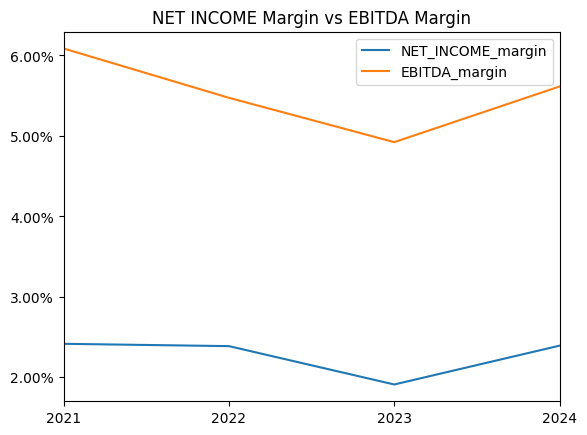

In [101]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Assuming df_fin_ratios is your DataFrame containing the financial ratios
# Make sure you have already created this DataFrame

# Plotting the specified columns
ax = df_fin_ratios[['NET_INCOME_margin','EBITDA_margin']].plot.line()

# Setting the y-axis formatter to display values as percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Adding title
plt.title('NET INCOME Margin vs EBITDA Margin')

# Displaying the plot
plt.show()
     

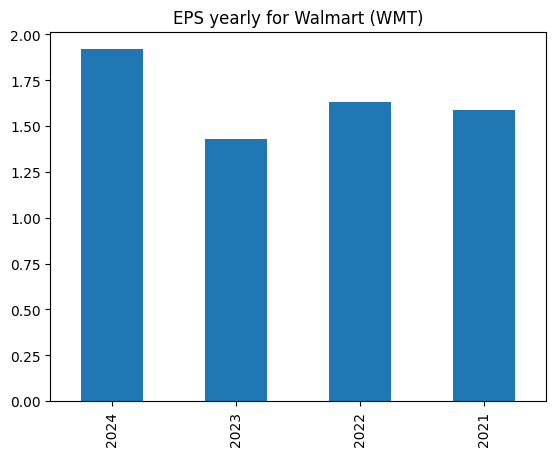

In [102]:
EPS_year = df_fin_ratios['EPS'].index.year

df_fin_ratios['EPS'].plot.bar(title = 'EPS yearly for Walmart (WMT)')

plt.xticks(range(len(EPS_year)), EPS_year)
# Displaying the plot
plt.show()

In [103]:


# https://companiesmarketcap.com/usa/largest-companies-in-the-usa-by-market-cap/
US_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO','V', 'JPM']

# You're required to add EU_STOCKS and INDIA_STOCS
# https://companiesmarketcap.com/european-union/largest-companies-in-the-eu-by-market-cap/
EU_STOCKS = ['NVO','MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE','IDEXY','CDI.PA']

# https://companiesmarketcap.com/india/largest-companies-in-india-by-market-cap/
INDIA_STOCKS = ['RELIANCE.NS','TCS.NS','HDB','BHARTIARTL.NS','IBN','SBIN.NS','LICI.NS','INFY','ITC.NS','HINDUNILVR.NS','LT.NS']
     

ALL_TICKERS = US_STOCKS  + EU_STOCKS + INDIA_STOCKS
ALL_TICKERS
     


['MSFT',
 'AAPL',
 'GOOG',
 'NVDA',
 'AMZN',
 'META',
 'BRK-B',
 'LLY',
 'AVGO',
 'V',
 'JPM',
 'NVO',
 'MC.PA',
 'ASML',
 'RMS.PA',
 'OR.PA',
 'SAP',
 'ACN',
 'TTE',
 'SIE.DE',
 'IDEXY',
 'CDI.PA',
 'RELIANCE.NS',
 'TCS.NS',
 'HDB',
 'BHARTIARTL.NS',
 'IBN',
 'SBIN.NS',
 'LICI.NS',
 'INFY',
 'ITC.NS',
 'HINDUNILVR.NS',
 'LT.NS']

In [104]:

import time

stocks_df = pd.DataFrame({'A' : []})

for i,ticker in enumerate(ALL_TICKERS):
  print(i,ticker)

  # Work with stock prices
  historyPrices = yf.download(tickers = ticker,
                     period = "max",
                     interval = "1d")

  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date

  # historical returns
  for i in [1,3,7,30,90,365]:
    historyPrices['growth_'+str(i)+'d'] = historyPrices['Adj Close'] / historyPrices['Adj Close'].shift(i)
  historyPrices['growth_future_5d'] = historyPrices['Adj Close'].shift(-5) / historyPrices['Adj Close']

  # Technical indicators
  # SimpleMovingAverage 10 days and 20 days
  historyPrices['SMA10']= historyPrices['Close'].rolling(10).mean()
  historyPrices['SMA20']= historyPrices['Close'].rolling(20).mean()
  historyPrices['growing_moving_average'] = np.where(historyPrices['SMA10'] > historyPrices['SMA20'], 1, 0)
  historyPrices['high_minus_low_relative'] = (historyPrices.High - historyPrices.Low) / historyPrices['Adj Close']

  # 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
  historyPrices['volatility'] =   historyPrices['Adj Close'].rolling(30).std() * np.sqrt(252)

  # what we want to predict
  historyPrices['is_positive_growth_5d_future'] = np.where(historyPrices['growth_future_5d'] > 1, 1, 0)

  # sleep 1 sec between downloads - not to overload the API server
  time.sleep(1)


  if stocks_df.empty:
    stocks_df = historyPrices
  else:
    stocks_df = pd.concat([stocks_df, historyPrices], ignore_index=True)

0 MSFT


[*********************100%%**********************]  1 of 1 completed


1 AAPL


[*********************100%%**********************]  1 of 1 completed


2 GOOG


[*********************100%%**********************]  1 of 1 completed


3 NVDA


[*********************100%%**********************]  1 of 1 completed


4 AMZN


[*********************100%%**********************]  1 of 1 completed


5 META


[*********************100%%**********************]  1 of 1 completed


6 BRK-B


[*********************100%%**********************]  1 of 1 completed


7 LLY


[*********************100%%**********************]  1 of 1 completed


8 AVGO


[*********************100%%**********************]  1 of 1 completed


9 V


[*********************100%%**********************]  1 of 1 completed


10 JPM


[*********************100%%**********************]  1 of 1 completed


11 NVO


[*********************100%%**********************]  1 of 1 completed


12 MC.PA


[*********************100%%**********************]  1 of 1 completed


13 ASML


[*********************100%%**********************]  1 of 1 completed


14 RMS.PA


[*********************100%%**********************]  1 of 1 completed


15 OR.PA


[*********************100%%**********************]  1 of 1 completed


16 SAP


[*********************100%%**********************]  1 of 1 completed


17 ACN


[*********************100%%**********************]  1 of 1 completed


18 TTE


[*********************100%%**********************]  1 of 1 completed


19 SIE.DE


[*********************100%%**********************]  1 of 1 completed


20 IDEXY


[*********************100%%**********************]  1 of 1 completed


21 CDI.PA


[*********************100%%**********************]  1 of 1 completed


22 RELIANCE.NS


[*********************100%%**********************]  1 of 1 completed


23 TCS.NS


[*********************100%%**********************]  1 of 1 completed


24 HDB


[*********************100%%**********************]  1 of 1 completed


25 BHARTIARTL.NS


[*********************100%%**********************]  1 of 1 completed


26 IBN


[*********************100%%**********************]  1 of 1 completed


27 SBIN.NS


[*********************100%%**********************]  1 of 1 completed


28 LICI.NS


[*********************100%%**********************]  1 of 1 completed


29 INFY


[*********************100%%**********************]  1 of 1 completed


30 ITC.NS


[*********************100%%**********************]  1 of 1 completed


31 HINDUNILVR.NS


[*********************100%%**********************]  1 of 1 completed


32 LT.NS


[*********************100%%**********************]  1 of 1 completed


In [105]:


def get_ticker_type(ticker:str, us_stocks_list, eu_stocks_list, india_stocks_list):
  if ticker in us_stocks_list:
    return 'US'
  elif ticker in eu_stocks_list:
    return 'EU'
  elif ticker in india_stocks_list:
    return 'INDIA'
  else:
    return 'ERROR'

     


In [106]:
stocks_df['ticker_type'] = stocks_df.Ticker.apply(lambda x:get_ticker_type(x, US_STOCKS, EU_STOCKS, INDIA_STOCKS))

In [107]:
stocks_df.ticker_type.value_counts()

ticker_type
US       80706
EU       77047
INDIA    63323
Name: count, dtype: int64

In [108]:
stocks_df.Ticker.nunique()

33

In [109]:
stocks_df.Ticker.value_counts()

Ticker
LLY              13093
JPM              11127
AAPL             10939
NVO              10844
MSFT              9613
CDI.PA            8326
TTE               8191
ASML              7336
SAP               7207
HINDUNILVR.NS     7120
SBIN.NS           7118
RELIANCE.NS       7117
ITC.NS            7117
BRK-B             7044
SIE.DE            7044
AMZN              6787
NVDA              6362
INFY              6329
MC.PA             6256
RMS.PA            6256
OR.PA             6256
IBN               6064
ACN               5734
HDB               5733
LT.NS             5425
BHARTIARTL.NS     5422
TCS.NS            5393
GOOG              4961
V                 4060
AVGO              3711
IDEXY             3597
META              3009
LICI.NS            485
Name: count, dtype: int64

In [110]:
stocks_df.groupby(['Ticker','ticker_type']).Date.agg(['min','max'])

,,min,max
Ticker,ticker_type,,
AAPL,US,1980-12-12,2024-05-03
ACN,EU,2001-07-19,2024-05-03
AMZN,US,1997-05-15,2024-05-03
ASML,EU,1995-03-15,2024-05-03
AVGO,US,2009-08-06,2024-05-03
BHARTIARTL.NS,INDIA,2002-07-01,2024-05-03
BRK-B,US,1996-05-09,2024-05-03
CDI.PA,EU,1992-01-27,2024-05-03
GOOG,US,2004-08-19,2024-05-03


In [111]:
#  average growth 365days
stocks_df[stocks_df.Year>=2020].groupby(by=['Year','ticker_type']).growth_365d.mean()

Year  ticker_type
2020  EU             1.245388
      INDIA          1.101896
      US             1.484070
2021  EU             1.582170
      INDIA          1.546424
      US             1.797571
2022  EU             1.191169
      INDIA          1.379889
      US             1.182379
2023  EU             1.246533
      INDIA          1.201110
      US             1.203253
2024  EU             1.641697
      INDIA          1.302823
      US             2.158508
Name: growth_365d, dtype: float64

In [112]:
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'])

In [113]:

# filtering only on stats after 2000
stocks_df[stocks_df.Date>='2000-01-01'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182609 entries, 3490 to 221075
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Open                          182609 non-null  float64       
 1   High                          182609 non-null  float64       
 2   Low                           182609 non-null  float64       
 3   Close                         182609 non-null  float64       
 4   Adj Close                     182609 non-null  float64       
 5   Volume                        182609 non-null  int64         
 6   Ticker                        182609 non-null  object        
 7   Year                          182609 non-null  int32         
 8   Month                         182609 non-null  int32         
 9   Weekday                       182609 non-null  int32         
 10  Date                          182609 non-null  datetime64[ns]
 11  growth_1d      

In [114]:
stocks_df[stocks_df.Date=='2024-04-01'].tail()

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,growth_90d,growth_365d,growth_future_5d,SMA10,SMA20,growing_moving_average,high_minus_low_relative,volatility,is_positive_growth_5d_future,ticker_type
195063,925.000000,984.450012,924.000000,970.599976,970.599976,4863536,LICI.NS,2024,4,0,...,1.599113,1.556710,1.026891,906.085004,953.950003,0,0.062281,1034.237352,1,INDIA
201389,17.889999,17.920000,17.500000,17.580000,17.580000,14601600,INFY,2024,4,0,...,1.003998,1.024508,1.015927,18.156000,18.777500,0,0.023891,13.940634,1,INDIA
208509,429.100006,431.350006,425.750000,426.700012,426.700012,9382308,ITC.NS,2024,4,0,...,0.987044,1.314436,1.005625,422.235004,416.537502,1,0.013124,130.246651,1,INDIA
215629,2270.000000,2295.000000,2262.000000,2285.899902,2285.899902,1427873,HINDUNILVR.NS,2024,4,0,...,0.917590,0.894050,0.992585,2266.539990,2327.240015,0,0.014436,1049.970071,0,INDIA
221054,3780.850098,3851.850098,3780.850098,3838.000000,3838.000000,1905190,LT.NS,2024,4,0,...,1.257886,2.010850,0.992144,3626.594971,3618.109985,1,0.018499,2188.619806,0,INDIA


### Question 3: Is Growth Concentrated in the Largest Stocks?

**Get the share of days (percentage as int) when Large Stocks outperform (growth_7d - growth over 7 periods back) the Largest stocks?**


Reuse [Code Snippet 5] to obtain OHLCV stats for 33 stocks 
for 10 full years of data (2014-01-01 to 2023-12-31). You'll need to download slightly more data (7 periods before 2014-01-01 to calculate the growth_7d for the first 6 days correctly):

`US_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO','V', 'JPM']`

`EU_STOCKS = ['NVO','MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE','IDEXY','CDI.PA']`

`INDIA_STOCKS = ['RELIANCE.NS','TCS.NS','HDB','BHARTIARTL.NS','IBN','SBIN.NS','LICI.NS','INFY','ITC.NS','HINDUNILVR.NS','LT.NS']`

`LARGEST_STOCKS = US_STOCKS + EU_STOCKS + INDIA_STOCKS`
<br/>

Now let's add the top 12-22 stocks (as of end-April 2024):
<br/>

`NEW_US = ['TSLA','WMT','XOM','UNH','MA','PG','JNJ','MRK','HD','COST','ORCL']`

`NEW_EU = ['PRX.AS','CDI.PA','AIR.PA','SU.PA','ETN','SNY','BUD','DTE.DE','ALV.DE','MDT','AI.PA','EL.PA']`

`NEW_INDIA = ['BAJFINANCE.NS','MARUTI.NS','HCLTECH.NS','TATAMOTORS.NS','SUNPHARMA.NS','ONGC.NS','ADANIENT.NS','ADANIENT.NS','NTPC.NS','KOTAKBANK.NS','TITAN.NS']`

`LARGE_STOCKS = NEW_EU + NEW_US + NEW_INDIA`

You should be able to obtain stats for 33 LARGEST STOCKS and 32 LARGE STOCKS (from the actual stats on Yahoo Finance)

Calculate  `growth_7d` for every stock and every day.
Get the average daily `growth_7d` for the LARGEST_STOCKS group vs. the LARGE_STOCKS group.

For example, for the first of data you should have:
| Date   |      ticker_category      |  growth_7d |
|----------|:-------------:|------:|
| 2014-01-01 |  LARGE | 1.011684 |
| 2014-01-01 |   LARGEST   |   1.011797 |

On that day, the LARGEST group was growing faster than LARGE one (new stocks).

Calculate the number of days when the LARGE GROUP (new smaller stocks) outperforms the LARGEST GROUP, divide it by the total number of trading days (which should be 2595 days), and convert it to a percentage (closest INTEGER value). For example, if you find that 1700 out of 2595 days meet this condition, it means that 1700/2595 = 0.655, or approximately 66% of days, the LARGE stocks were growing faster than the LARGEST ones. This suggests that you should consider extending your dataset with more stocks to seek higher growth.

HINT: you can use pandas.pivot_table() to "flatten" the table (LARGE and LARGEST growth_7d as columns)
